# **Generative AI**

## **Definition and Overview**

**Definition**

Generative AI refers to artificial intelligence systems that can create new content, such as text, images, audio, video, or other data, by learning patterns from existing data. These systems use machine learning models, often based on neural networks, to generate outputs that mimic or creatively extend the characteristics of their training data.

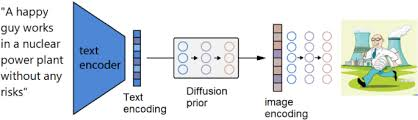

| Model                     | What It Generates          | Core Idea                                       |
| ------------------------- | -------------------------- | ----------------------------------------------- |
| **VAEs**                  | Images, audio              | Encode + decode, probabilistic latent space     |
| **GANs**                  | High-res images, videos    | Competing networks (Generator vs Discriminator) |
| **Diffusion Models**      | Ultra-realistic images     | Iterative denoising from pure noise             |
| **Autoregressive Models** | Text, music, code          | Predict next token step by step                 |
| **Transformers (LLMs)**   | Text, code, reasoning      | Attention-based sequence modeling               |
| **Flow Models**           | Invertible data generation | Learn exact likelihood and sampling             |


## **AEs and VAEs**

### AutoEnconders

An Autoencoder (AE) is an unsupervised neural network architecture used for learning efficient data encodings. It aims to compress input data into a latent-space representation and then reconstruct the output from this compressed form.

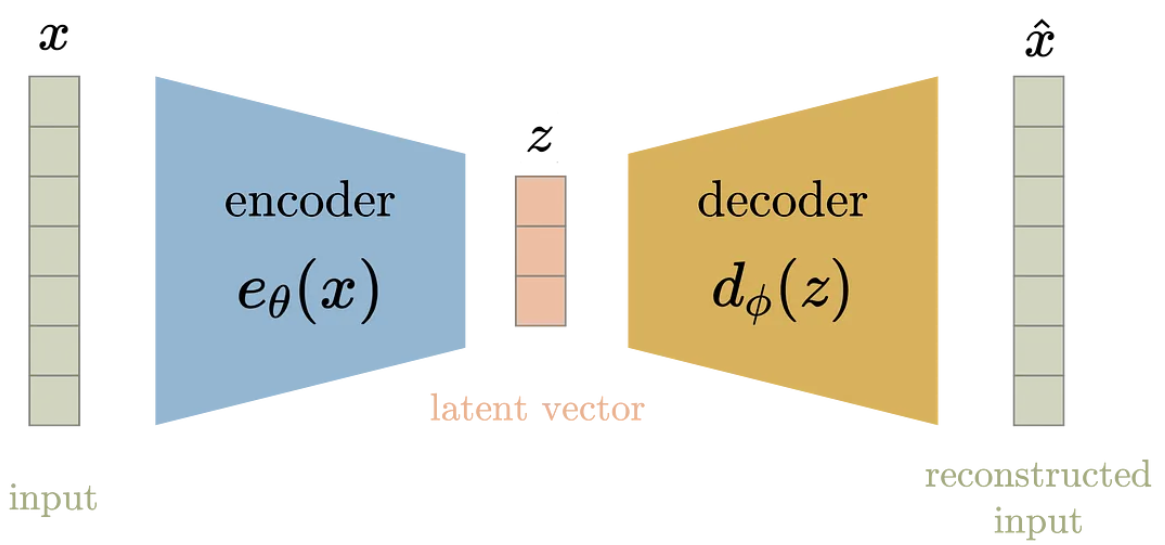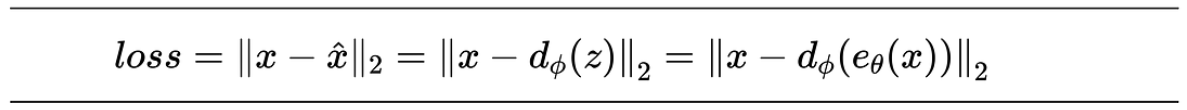


[medium.com]

### Variational AutoEncoders

A Variational Autoencoder (VAE) is a generative model that extends the AE by learning the underlying distribution of the data. Instead of learning a deterministic latent code, VAE learns a probabilistic latent space, allowing for the generation of new data.



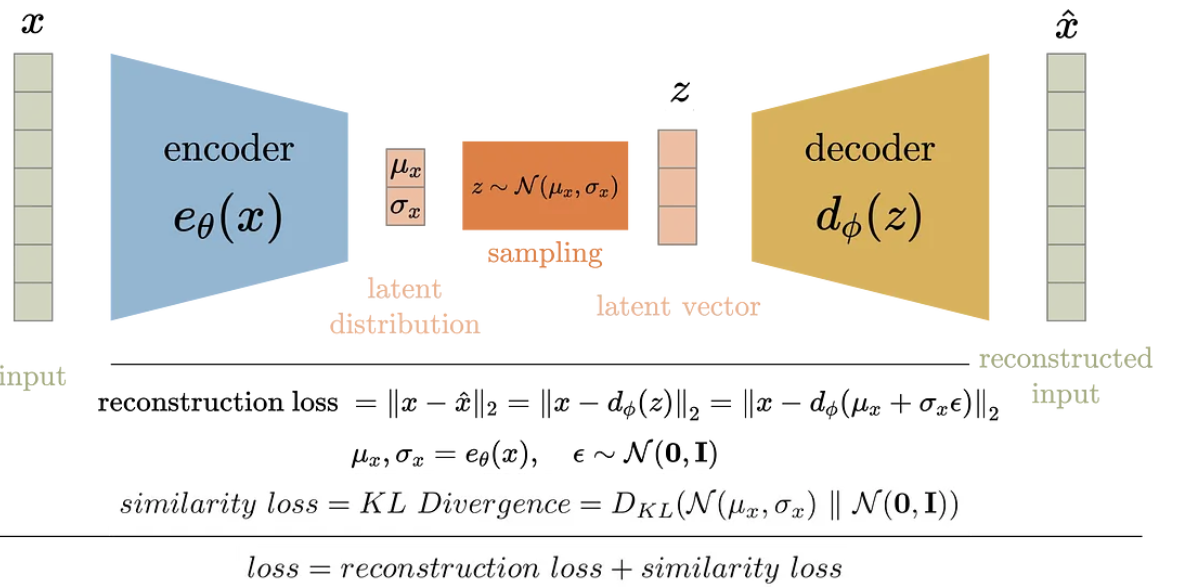

[medium.com]

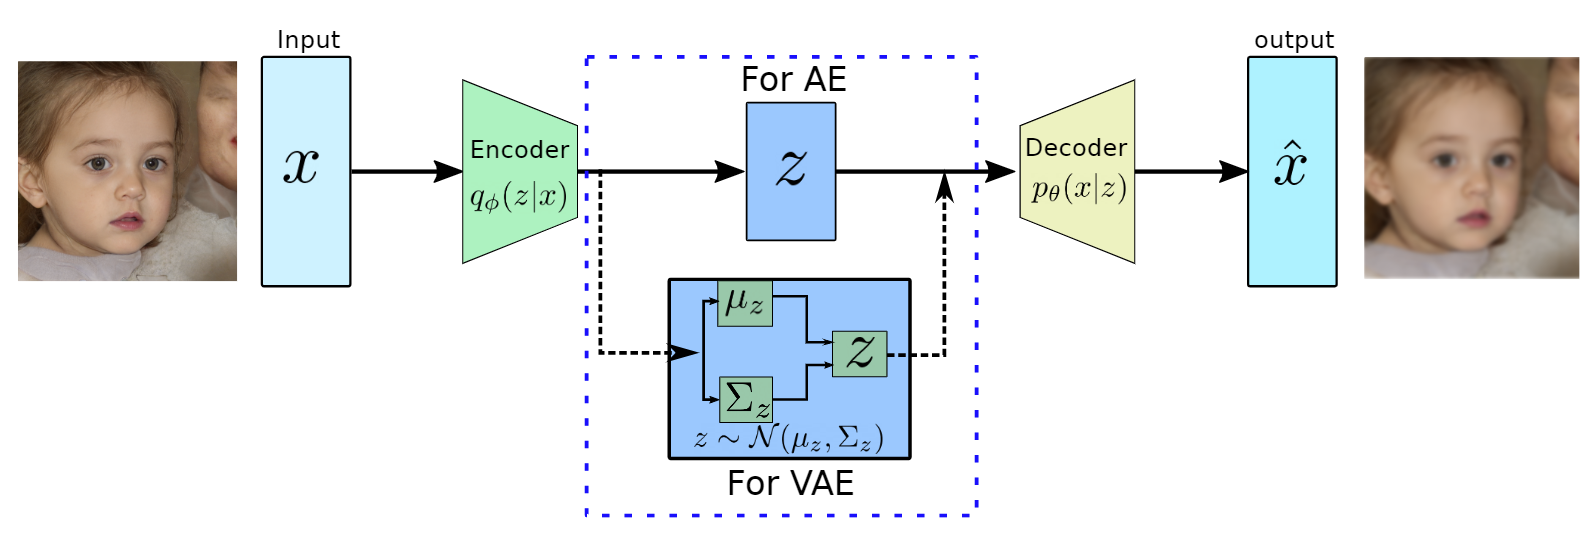

| Model | Strength in GenAI                        | Key Use Cases                                                      |
| ----- | ---------------------------------------- | ------------------------------------------------------------------ |
| AE    | Efficient latent representation          | Denoising, anomaly detection, style transfer                       |
| VAE   | Generative modeling with latent sampling | Image/text/audio generation, interpolation, conditional generation |


## **Generative Adversarial Networks (GANs)**

GANs (generative adversarial networks) are clever machine learning (ML) algorithms that use neural networks (simplified computer models of the brain) in a specific way.

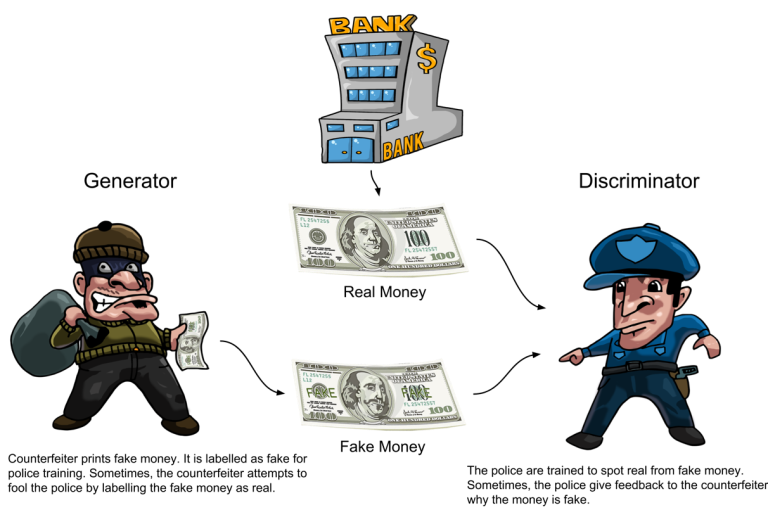

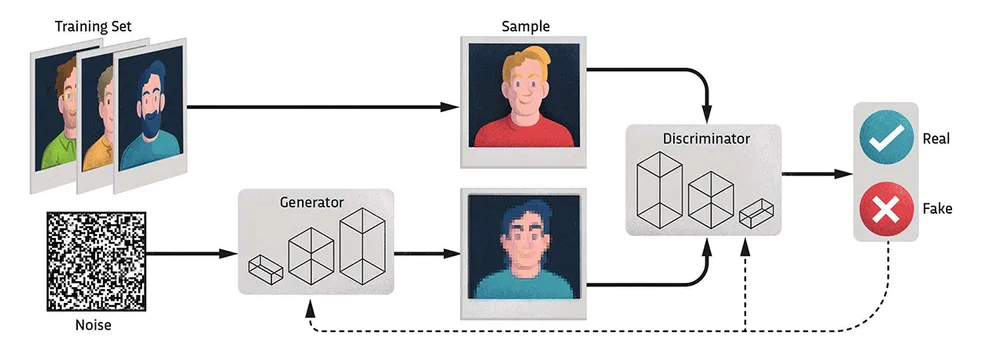

[sciencefocus.com]

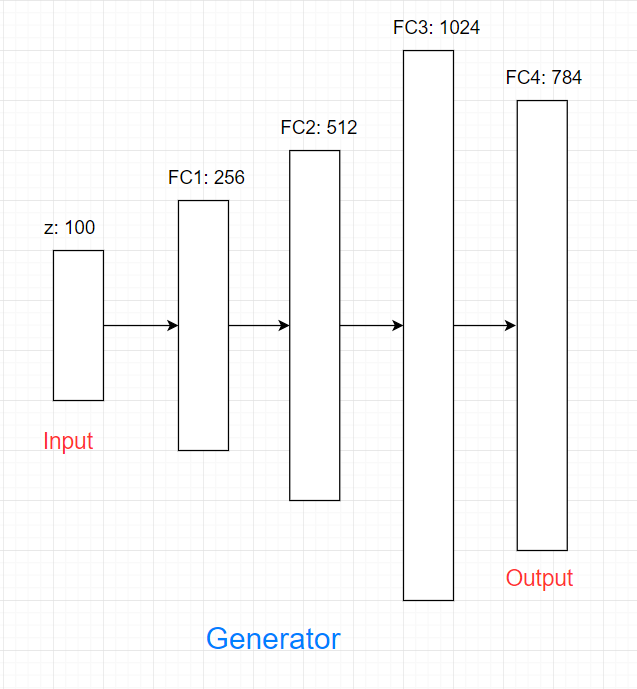

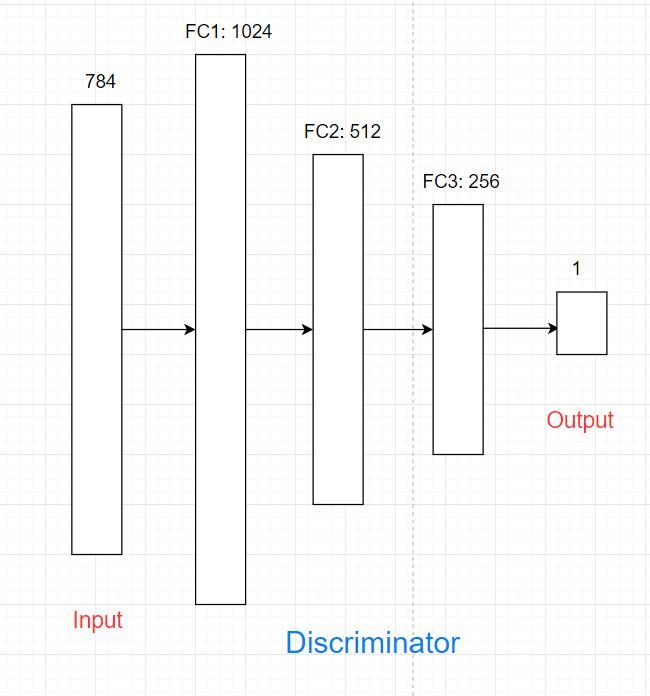

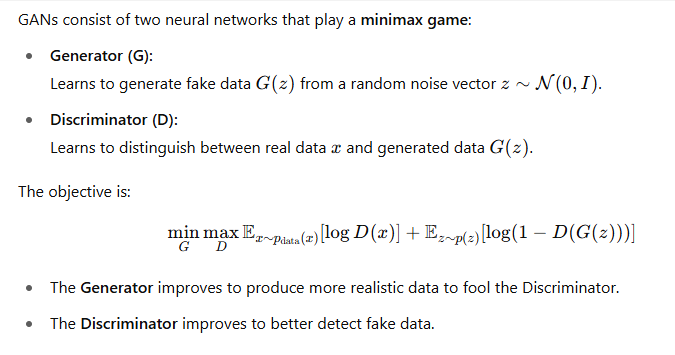

## **Diffusion**

Diffusion models are generative models used primarily for image generation and other computer vision tasks. Diffusion-based neural networks are trained through deep learning to progressively “diffuse” samples with random noise, then reverse that diffusion process to generate high-quality images.

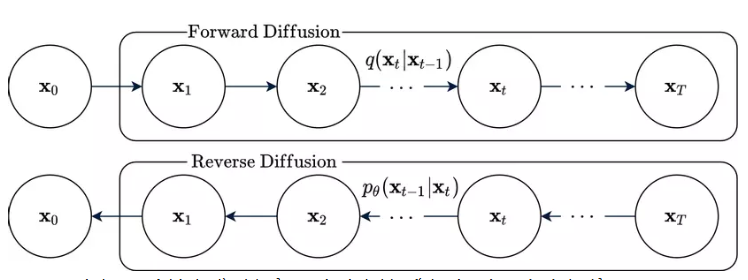

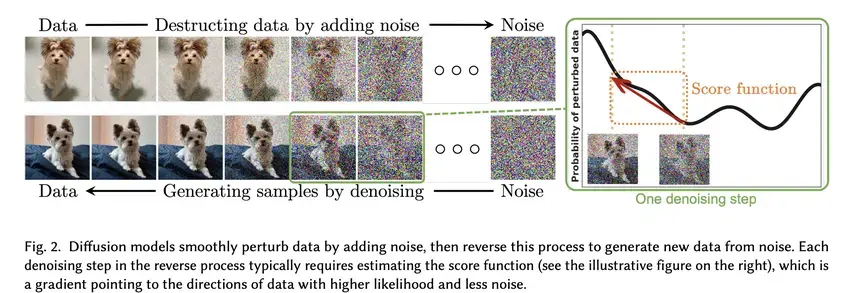

[https://www.superannotate.com/]

### ***Stable Diffusion***

Stable Diffusion is a text-to-image latent diffusion model (LDM) introduced by the CompVis group in 2022. Unlike standard diffusion models that operate in pixel space, Stable Diffusion applies the denoising process in a compressed latent space, allowing high-quality image generation with much lower computational cost.

So what happens since we add a prompt ??

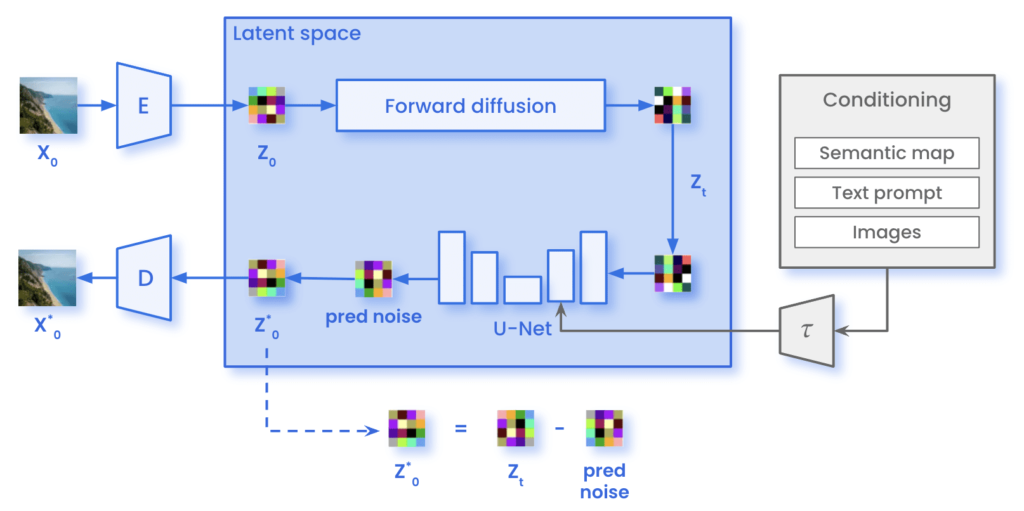

CLIP with the relationship visualization:

[Projector TensorFlow](https://projector.tensorflow.org/)



## **Comparison** - OPTIONAL

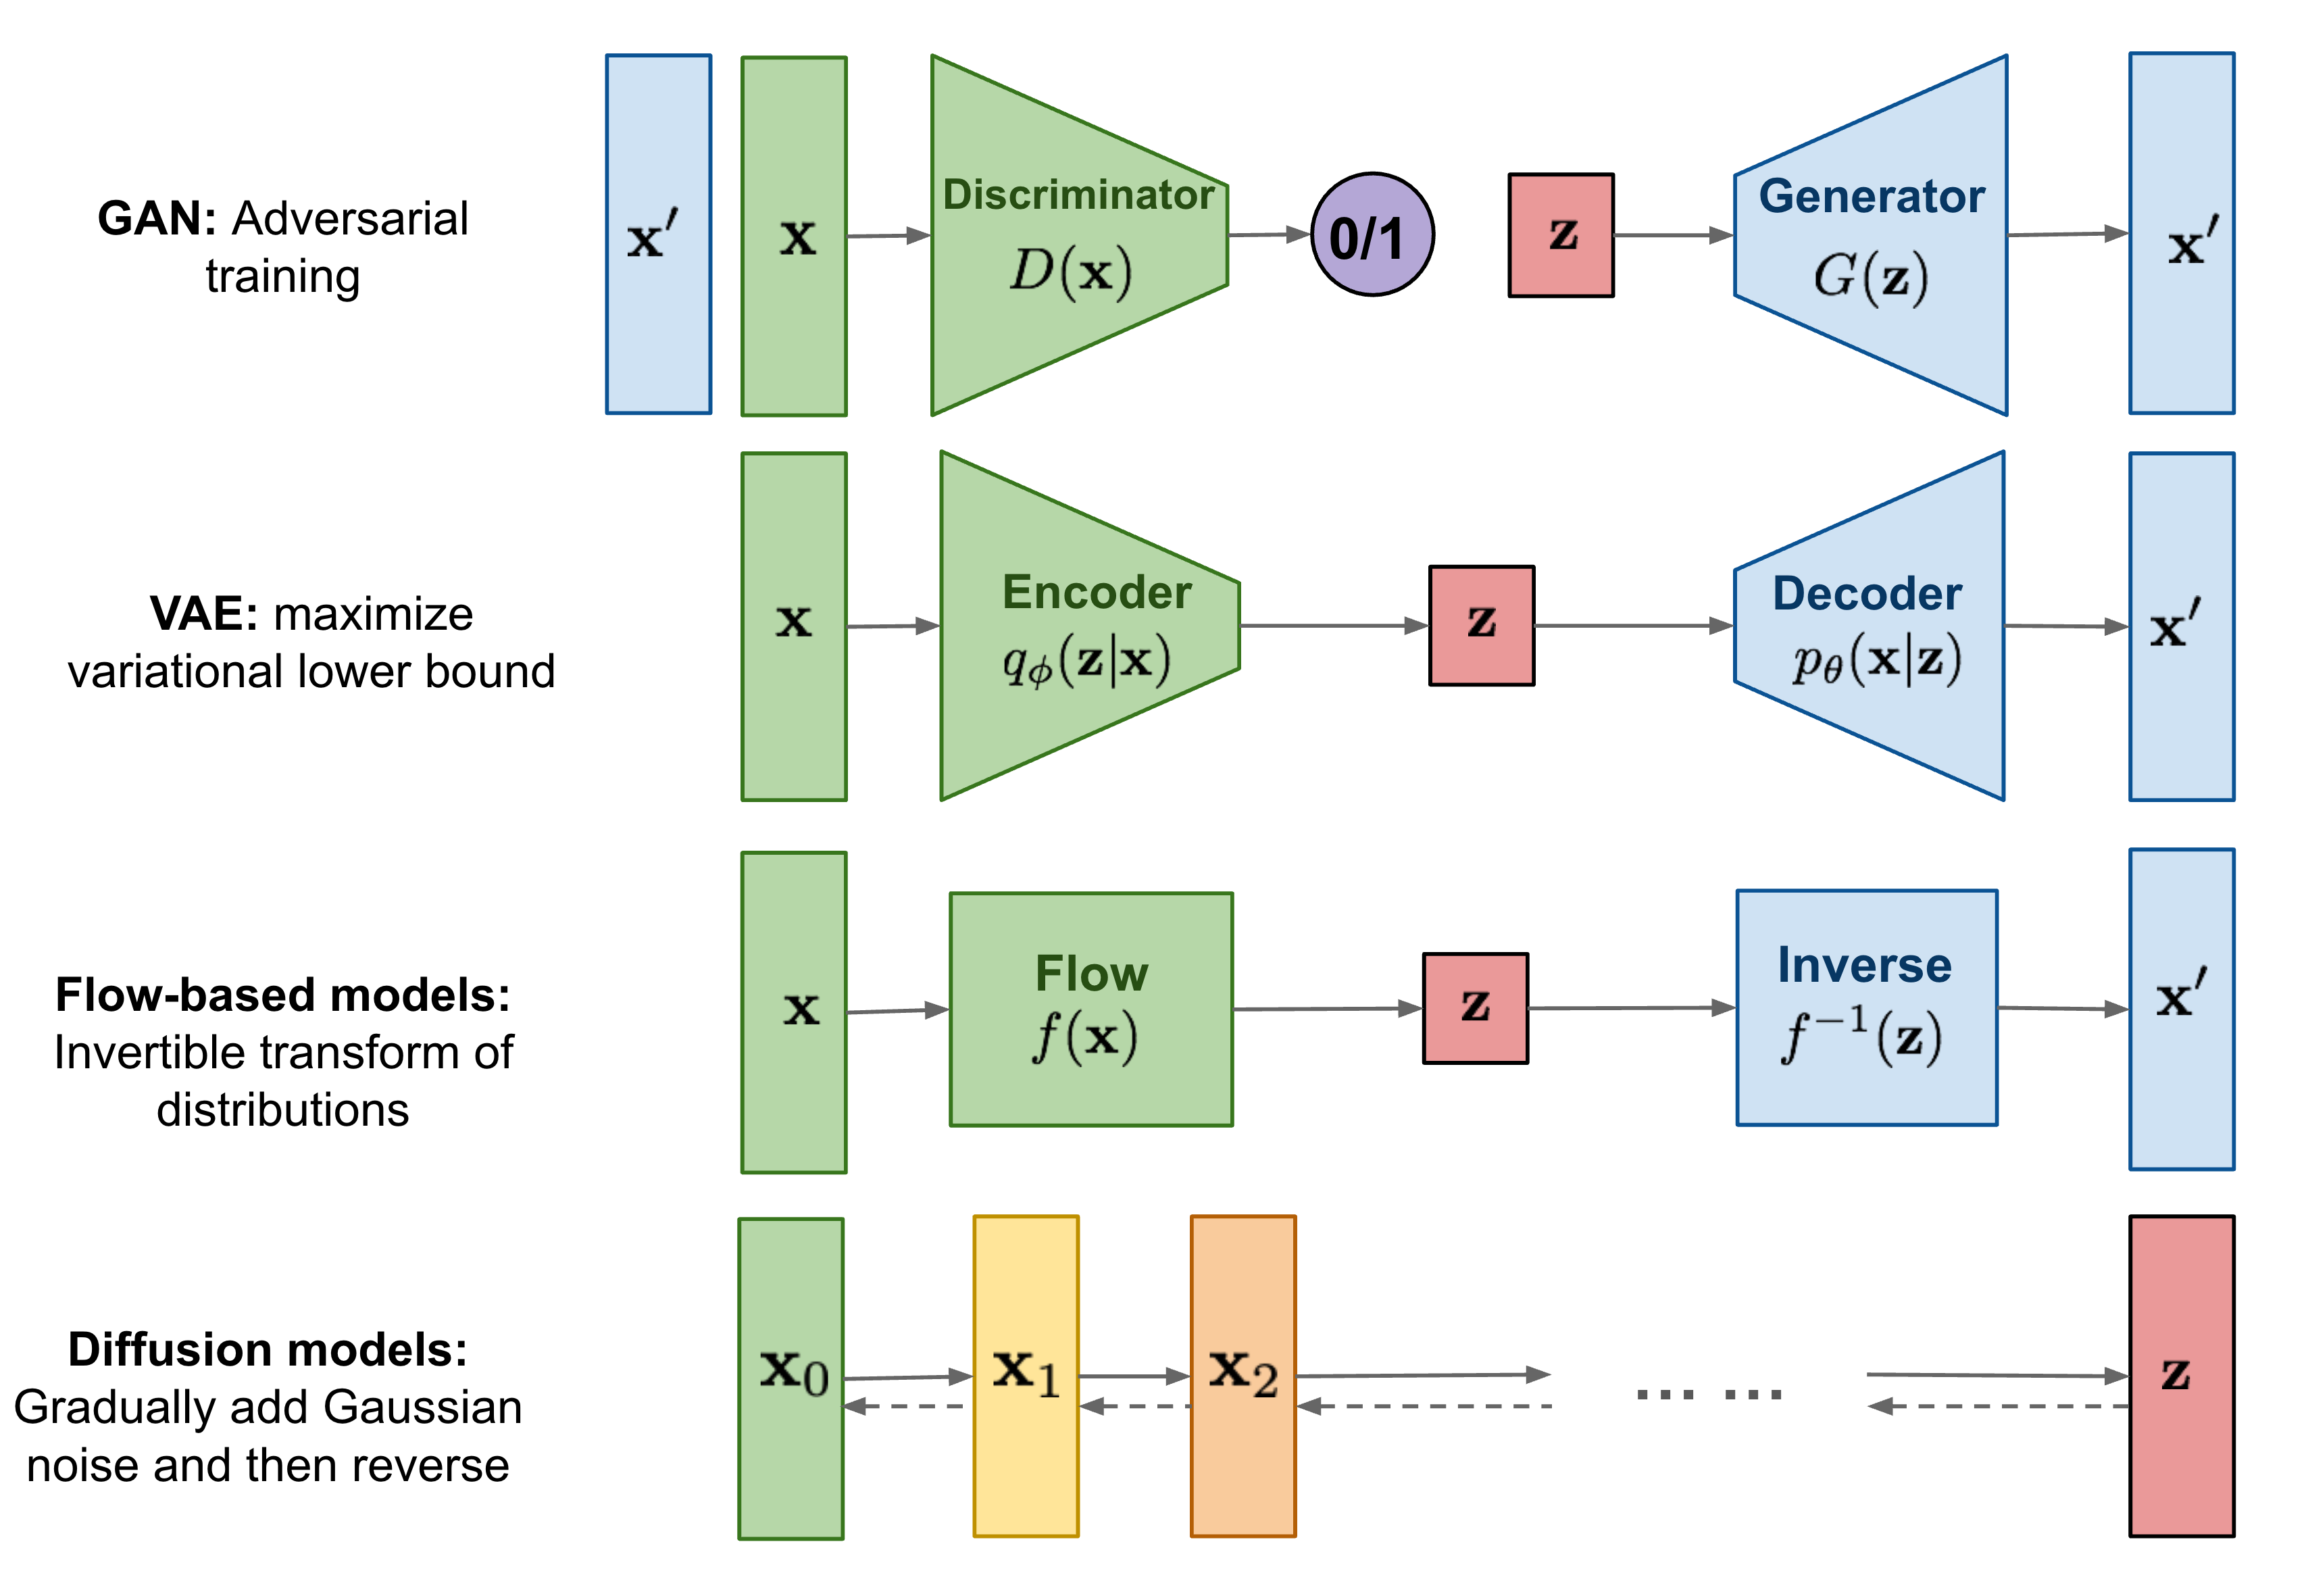

| Aspect                 | **Variational Autoencoder (VAE)**                                          | **Generative Adversarial Network (GAN)**                          | **Diffusion Model**                                                             |
| ---------------------- | -------------------------------------------------------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **Core Idea**          | Encode data into latent space and decode with reconstruction + KL loss     | Train a generator to fool a discriminator in an adversarial setup | Model data generation as a reverse denoising process from noise                 |
| **Training Objective** | Maximize Evidence Lower Bound (ELBO) = Reconstruction Loss + KL Divergence | Minimax Game: Generator vs. Discriminator                         | Learn reverse diffusion process by minimizing denoising error                   |
| **Architecture**       | Encoder + Decoder                                                          | Generator + Discriminator                                         | Denoising U-Net or Transformer (often unpaired)                                 |
| **Sampling Process**   | Fast (1-step decode from latent z)                                         | Fast (1 forward pass through generator)                           | Slow (many denoising steps, e.g., 50–1000 steps)                                |
| **Training Stability** | Stable and easy to train                                                   | Often unstable (mode collapse, non-convergence)                   | Stable but computationally expensive                                            |
| **Output Quality**     | Decent, often blurry due to Gaussian assumptions                           | Sharp, high-fidelity images                                       | Extremely realistic and high-quality images                                     |
| **Latent Space**       | Explicit, structured latent space (e.g., Gaussian)                         | Implicit, not always meaningful                                   | Usually implicit, but newer methods add latent control (e.g., Latent Diffusion) |
| **Controllability**    | Good for interpolation and latent editing                                  | Difficult without extra mechanisms (e.g., Conditional GANs)       | Emerging; latent diffusion allows control; prompt-based conditioning is strong  |
| **Use Cases**          | Representation learning, anomaly detection, image interpolation            | Image generation, style transfer, deepfakes                       | Text-to-image generation (e.g., Stable Diffusion), inpainting, super-resolution |
| **Advantages**               | Interpretable latent space, stable training                                | High visual fidelity, fast inference                              | Best quality outputs, flexible conditioning                                     |
| **Disadvantages**               | Blurry outputs, limited expressiveness                                     | Mode collapse, hard to train                                      | Slow inference, high compute requirement                                        |


#Practice

## VAEs

In [5]:
# ✅ 1. Install and Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Step 1: finished") #just for debugging if needed

# ✅ 2. Load the MNIST Dataset
transform = transforms.ToTensor()

# Download full MNIST dataset
full_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Filter only digit '5'
indices = [i for i, target in enumerate(full_train.targets) if target == 5]
subset = Subset(full_train, indices)

# DataLoader
train_loader = DataLoader(subset, batch_size=64, shuffle=True)
print(f"Number of digit-4 samples: {len(subset)}")
print("Step 2: finished")

Step 1: finished
Number of digit-4 samples: 5421
Step 2: finished


In [ ]:
# ✅ 3. Define the VAE Model

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder: Fully connected layer to reduce input dimension
        self.fc1 = nn.Linear(28*28, 400)  # Input layer: 784 → 400

        # Latent space mappings
        self.fc_mu = nn.Linear(400, latent_dim)      # Mean vector (μ): 400 → latent_dim
        self.fc_logvar = nn.Linear(400, latent_dim)  # Log-variance (logσ²): 400 → latent_dim

        # Decoder: reconstruct from latent space
        self.fc_decode = nn.Linear(latent_dim, 400)  # Latent vector z → 400
        self.fc_out = nn.Linear(400, 28*28)          # Output layer: 400 → 784 (28×28 image)

        # Activation functions
        self.relu = nn.ReLU()        # Used in hidden layers
        self.sigmoid = nn.Sigmoid()  # Used in output layer to squash values to [0,1]


    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = self.relu(self.fc_decode(z))
        return self.sigmoid(self.fc_out(h2))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# ✅ 4. Loss Function and Optimizer

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Step 3,4: finished")


Step 3,4: finished


In [ ]:
# ✅ 5. Training Loop

epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(train_loader.dataset):.2f}")
print("Step 5: finished")


Epoch [1/10] Loss: 226.94
Epoch [2/10] Loss: 160.03
Epoch [3/10] Loss: 145.98
Epoch [4/10] Loss: 136.39
Epoch [5/10] Loss: 129.67
Epoch [6/10] Loss: 125.32
Epoch [7/10] Loss: 122.14
Epoch [8/10] Loss: 119.53
Epoch [9/10] Loss: 117.40
Epoch [10/10] Loss: 115.87
Step 5: finished


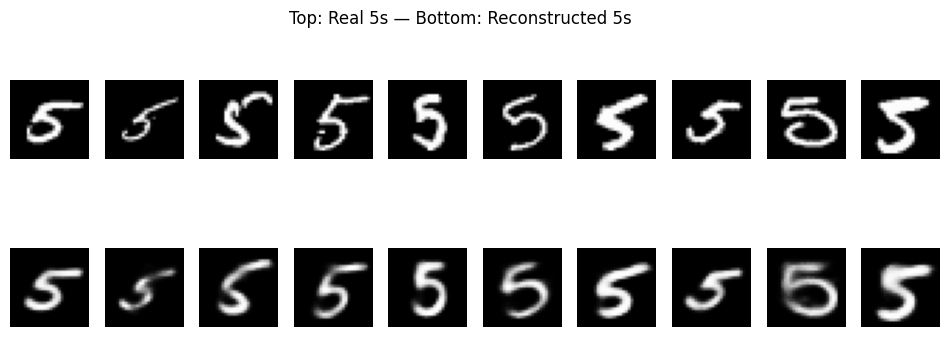

In [ ]:
# ✅ 6. Visualize Reconstruction

model.eval()
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        recon, _, _ = model(x)
        break

    x = x.view(-1, 1, 28, 28).cpu()
    recon = recon.view(-1, 1, 28, 28).cpu()

    plt.figure(figsize=(12, 4))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i+11)
        plt.imshow(recon[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Top: Real 5s — Bottom: Reconstructed 5s")
    plt.show()



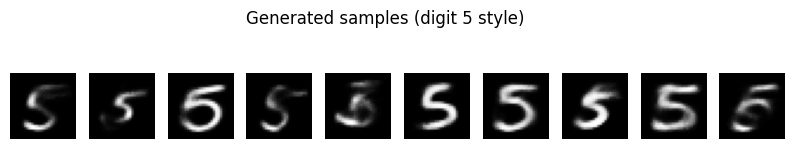

In [ ]:
with torch.no_grad():
    z = torch.randn(10, 20).to(device)
    samples = model.decode(z).cpu().view(-1, 1, 28, 28)

    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(samples[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated samples (digit 5 style)")
    plt.show()


## GANs

In [ ]:
# 1. Set up
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

device = torch.device("cpu")

# 2. Load digit "4"
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
digit4_indices = [i for i, label in enumerate(mnist.targets) if label == 4]
digit4_subset = Subset(mnist, digit4_indices)
train_loader = DataLoader(digit4_subset, batch_size=64, shuffle=True)
print(f"Training only on digit '4': {len(digit4_subset)} samples")

Training only on digit '4': 5842 samples


In [ ]:
latent_dim = 100  # Dimension of the input noise vector (z)
# 3. Define generator and discriminator

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Input: latent vector z of size 100
            nn.Linear(latent_dim, 256),  # → hidden layer
            nn.ReLU(),                   # → activation

            nn.Linear(256, 512),         # increase complexity
            nn.ReLU(),

            nn.Linear(512, 784),         # Output: 28×28 image flattened
            nn.Tanh()                    # Output pixel range: [-1, 1]
        )

    def forward(self, z):
        # Forward pass through generator
        return self.net(z).view(-1, 1, 28, 28)  # Reshape to image format


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),              # Flatten 28×28 image → 784
            nn.Linear(784, 512),       # → hidden layer
            nn.LeakyReLU(0.2),         # LeakyReLU helps gradient flow

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 1),         # Output: single scalar (real/fake)
            nn.Sigmoid()               # Output range: [0, 1] (probability)
        )

    def forward(self, x):
        return self.net(x)



In [ ]:
# 4. Initialize Models and Optimizers
# Instantiate Generator and Discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Binary cross-entropy loss for GAN
loss_fn = nn.BCELoss()

# Adam optimizers (standard for GAN training)
opt_G = optim.Adam(G.parameters(), lr=2e-4)
opt_D = optim.Adam(D.parameters(), lr=2e-4)

# 5. Traning
epochs = 20
for epoch in range(epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device) * 2 - 1  # Normalize to [-1, 1]

        # === Train Discriminator ===
        # Step 1: Train D to classify real and fake images correctly
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = G(z).detach()  # No grad update to G

        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs)
        D_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        # === Train Generator ===
        # Step 2: Train G to fool D (want D(G(z)) = 1)
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = G(z)
        G_loss = loss_fn(D(fake_imgs), real_labels)

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs}, D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")


Epoch 1/20, D_loss: 0.1418, G_loss: 3.6224
Epoch 2/20, D_loss: 0.0289, G_loss: 4.8440
Epoch 3/20, D_loss: 0.0653, G_loss: 4.3888
Epoch 4/20, D_loss: 0.0590, G_loss: 7.0805
Epoch 5/20, D_loss: 0.0475, G_loss: 6.3536
Epoch 6/20, D_loss: 0.0401, G_loss: 6.4371
Epoch 7/20, D_loss: 0.0847, G_loss: 6.8830
Epoch 8/20, D_loss: 0.1186, G_loss: 5.6227
Epoch 9/20, D_loss: 0.0563, G_loss: 5.9713
Epoch 10/20, D_loss: 0.0517, G_loss: 5.2613
Epoch 11/20, D_loss: 0.0961, G_loss: 2.7510
Epoch 12/20, D_loss: 0.5434, G_loss: 4.1278
Epoch 13/20, D_loss: 0.3551, G_loss: 6.4273
Epoch 14/20, D_loss: 0.3271, G_loss: 4.3460
Epoch 15/20, D_loss: 0.1777, G_loss: 5.5540
Epoch 16/20, D_loss: 0.3255, G_loss: 5.4922
Epoch 17/20, D_loss: 1.1382, G_loss: 4.8886
Epoch 18/20, D_loss: 0.5802, G_loss: 4.2210
Epoch 19/20, D_loss: 0.2759, G_loss: 7.3800
Epoch 20/20, D_loss: 0.2904, G_loss: 3.7544


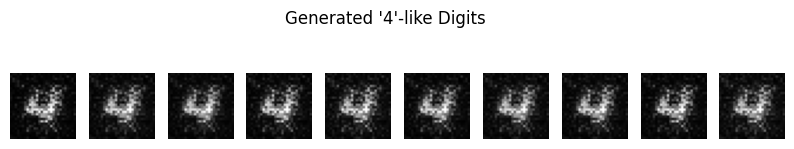

In [ ]:
# 6. Generate and Display Samples
G.eval()
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    samples = G(z).cpu() * 0.5 + 0.5  # Rescale from [-1, 1] to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(samples[i][0], cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated '4'-like Digits")
    plt.show()


## Stable Diffusion

### Traning

In [1]:
# 1. Pre-process: resize all images to a consistent size
import os
from PIL import Image

# Input and output folders
input_folder = '/content/drive/MyDrive/DatasetSD'
output_folder = '/content/drive/MyDrive/DatasetSD/resized'
os.makedirs(output_folder, exist_ok=True)

# Target image size (standard for Stable Diffusion)
target_size = (512, 512)

# List image files only (skip prompt.json)
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    # Open and resize
    img = Image.open(input_path).convert("RGB")
    img_resized = img.resize(target_size, Image.LANCZOS)  # High-quality downsampling
    img_resized.save(output_path)

print(f"✅ Resized {len(image_files)} images to 512×512 and saved to 'resized' folder.")


✅ Resized 6 images to 512×512 and saved to 'resized' folder.


In [2]:
# 2. Load resized images, load the corresponding text prompt, apply transforms for Stable Diffusion
import json
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class TextImageDataset(Dataset):
    def __init__(self, image_dir, json_path, size=512):
        self.image_dir = image_dir
        self.size = size

        # Load image → prompt mapping
        with open(json_path, 'r') as f:
            self.prompt_dict = json.load(f)

        # Sort keys to ensure consistent order
        self.image_filenames = sorted(self.prompt_dict.keys())

        # Image transform
        self.transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.BICUBIC),
            transforms.ToTensor(),  # [0,1]
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1,1]
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        prompt = self.prompt_dict[filename]

        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return {
            "image": image,
            "text": prompt,
            "filename": filename
        }


# Path to resized images and prompt.json
image_dir = "/content/drive/MyDrive/DatasetSD/resized"
json_path = "/content/drive/MyDrive/DatasetSD/prompt.json"

# Create the dataset
dataset = TextImageDataset(image_dir, json_path)

# Optional: wrap in DataLoader
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Test one sample
sample = next(iter(loader))
print("Text prompt:", sample['text'][0])
print("Image shape:", sample['image'][0].shape)


Text prompt: a dog holding a green ball is running on the grass
Image shape: torch.Size([3, 512, 512])


In [1]:
# 3. Tokenize Prompts using CLIP
!pip install transformers diffusers accelerate
# At this step, we use Hugging Face Transformers library to load the tokenizer and model.


In [6]:
from transformers import CLIPTokenizer, CLIPTextModel
import torch

# Load pretrained CLIP (text part only)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
# Example batch from your dataset
batch = next(iter(loader))
prompts = batch["text"]

# Tokenize prompts
inputs = tokenizer(prompts, padding="max_length", truncation=True, max_length=77, return_tensors="pt").to(device)

# Encode with CLIP
with torch.no_grad():
    embeddings = text_encoder(**inputs).last_hidden_state  # Shape: [batch_size, 77, 768]


In [7]:
# 4. Encode Images with VAE
# Stable Diffusion uses a pretrained Variational Autoencoder (VAE) to
# compress 512×512 images into a latent space (usually 64×64×4). This makes diffusion faster and more efficient.

######################################################

# Load the VAE Encoder
from diffusers import AutoencoderKL

# Load pretrained VAE (used in Stable Diffusion v1.4/1.5)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
vae.eval()

# Get image batch from dataset
images = batch["image"].to(device)  # shape: [B, 3, 512, 512]

# Encode image to latent space using VAE
with torch.no_grad():
    latents = vae.encode(images).latent_dist.sample()  # Sample from latent distribution
    latents = latents * 0.18215  # 0.18215 - Stability AI to match latent statistics with pixel-space outputs during training and sampling



config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [8]:
# 5. Add Noise and Train U-Net (Core of Diffusion)
'''
1./ We have a latent image z from VAE: z ∈ [B, 4, 64, 64] (batch size, channels, height, width)

2./ Sample a timestep t from 1 to T (usually 1000 steps)

3./ Add Gaussian noise to z → get z_noised

4./ Pass z_noised and text_embedding into U-Net

5./ U-Net tries to predict the noise that was added

6./ Compute loss between predicted noise and actual noise
'''
from diffusers import UNet2DConditionModel, DDPMScheduler
# Load Stable Diffusion's U-Net
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)
# Scheduler defines how noise is added at each timestep
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)



# Forward
# Step 1: Get latent and text embeddings
latents = latents.to(device)
text_embeddings = embeddings.to(device)  # shape: [B, 77, 768]

# Step 2: Sample a timestep for each image in the batch
batch_size = latents.shape[0]
timesteps = torch.randint(0, 1000, (batch_size,), device=device).long()

# Step 3: Add noise
noise = torch.randn_like(latents)  # random Gaussian noise
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

# Step 4: Predict noise with U-Net (conditioned on text)
with torch.no_grad():
    predicted_noise = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

# Step 5: Compute MSE loss between predicted and actual noise
loss_fn = torch.nn.MSELoss()
loss = loss_fn(predicted_noise, noise)

print("Loss:", loss.item())


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loss: 0.013185910880565643


In [ ]:
# Trainnnnn
from tqdm import tqdm
import torch.nn.functional as F

# Set to training mode
unet.train()
text_encoder.eval()
vae.eval()

# Optimizer for U-Net only
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-5)

# Epochs
num_epochs = 1

for epoch in range(num_epochs):
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    total_loss = 0

    for batch in loop:
        # === Prepare text ===
        prompts = batch["text"]
        inputs = tokenizer(prompts, padding="max_length", truncation=True, max_length=77, return_tensors="pt").to(device)
        with torch.no_grad():
            text_embeddings = text_encoder(**inputs).last_hidden_state

        # === Prepare image ===
        images = batch["image"].to(device)
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample() * 0.18215

        # === Sample timestep & noise ===
        bsz = latents.shape[0]
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (bsz,), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # === Predict noise using U-Net ===
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # === Compute loss ===
        loss = F.mse_loss(noise_pred, noise)

        # === Backprop ===
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1}: Avg Loss = {total_loss / len(loader):.4f}")

save_path = "/content/drive/MyDrive/DatasetSD/trained_unet"
unet.save_pretrained(save_path)
print("✅ U-Net saved to:", save_path)


Epoch 1/1:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# 6. Load Trained U-Net

# Load from saved path
unet = UNet2DConditionModel.from_pretrained(save_path).to(device)
from diffusers import StableDiffusionPipeline
import torch

# Load full pipeline and replace U-Net
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    revision="fp16" if torch.cuda.is_available() else None,
).to(device)

pipe.unet = unet  # Replace U-Net with fine-tuned version
pipe.enable_attention_slicing()

# Set prompt
prompt = "a yellow dog with a blue ball"

# Generate
with torch.autocast("cuda" if torch.cuda.is_available() else "cpu"):
    image = pipe(prompt, guidance_scale=7.5).images[0]

# Show
image.show()

### Testing

Online testing at: [Hugging Face - Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion)



In [2]:
!pip install -U diffusers

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

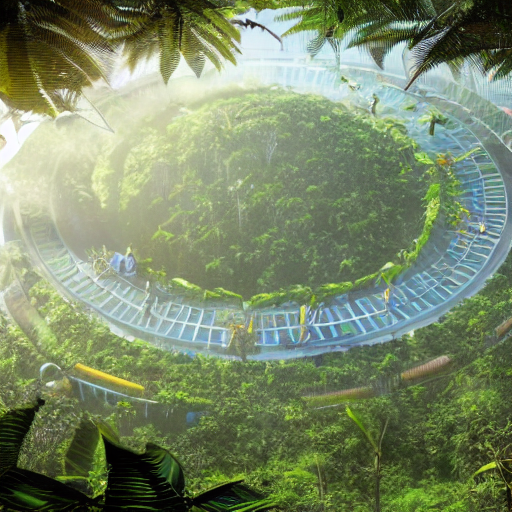

In [1]:
# Test with a pretrained model
from diffusers import DiffusionPipeline
from IPython.display import display

# Load the pipeline
pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda")  # Use GPU if available for faster generation

# Define prompt and generate image
prompt = "A high tech solarpunk utopia in the Amazon rainforest"
image = pipe(prompt).images[0]

# Display the image in Colab
display(image)
